In [ ]:
import os
from google.colab import drive
from google.colab import files
from IPython.display import Image
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/NLP Project')
os.getcwd()
!pip install tqdm
!pip install rank_bm25
!pip install ktrain
!pip install -U sentence-transformers
!pip install pot

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 50.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 64.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.6/653.6 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 96.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 98.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 52.8 MB/s et

In [ ]:
import nltk
import gensim
import ktrain
import torch
import os
import re
import pandas as pd
import numpy as np
import gensim.downloader as api
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from gensim.models import KeyedVectors
from gensim.similarities import WmdSimilarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, r2_score
from rank_bm25 import BM25Okapi
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sentence_transformers import SentenceTransformer, util
from torch.utils.data import DataLoader, Dataset, RandomSampler
from ktrain import text
from absl import logging
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

nltk.download('punkt')
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 8)
# uploaded = files.upload()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Utils

In [ ]:
def get_results(targets, preds):
  mse = mean_squared_error(targets, preds)
  rmse = mean_squared_error(targets, preds, squared=False)
  r2 = r2_score(targets, preds)

  print(f"MSE: {round(mse, 3)}")
  print(f"RMSE: {round(rmse, 3)}")
  print(f"R2: {round(r2, 3)}\n")

  return mse, rmse, r2

In [ ]:
from sklearn.model_selection import KFold
def find_polynomial_and_write_results(maxdegree, sim_train, val_train, sim_test, scorename, train_targets, val_targets, test_targets):
    # Initialize variables to store the best degree and the minimum error
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    mse_cv = []
    best_degree = 0
    min_error = float('inf')
    for degree in range(1, maxdegree):  # Loop through degrees 1 to 5. You can adjust this range as needed.
        # Create a PolynomialFeatures object
        poly = PolynomialFeatures(degree)
        mse_kfolds = []
        # Create a pipeline of polynomial transformation and linear regression
        poly_reg = make_pipeline(poly, LinearRegression())

        for train_index, valid_index in kf.split(sim_train):
            train_sim, valid_sim = sim_train[train_index], sim_train[valid_index]
            train_targ, valid_targ = train_targets[train_index], train_targets[valid_index]

            poly_reg.fit(train_sim, train_targ)
            poly_predictions_valid = poly_reg.predict(valid_sim)
            mse = mean_squared_error(valid_targ, poly_predictions_valid)
            mse_kfolds.append(mse)
        
        mse_avg = np.mean(mse_kfolds)
        mse_cv.append(mse_avg)

        print(f"Degree: {degree}, MSE: {mse}")

        # Update the best degree and minimum error if the current model performs better
        if mse < min_error:
            min_error = mse
            best_degree = degree

    print(f"Best degree: {best_degree}, MSE: {min_error}")

    poly = PolynomialFeatures(best_degree)
    reg = make_pipeline(poly, LinearRegression())

    reg.fit(similarity_train, train_targets)

    predictions_train = reg.predict(similarity_train)
    predictions_test = reg.predict(similarity_test)
    predictions_val = reg.predict(similarity_valid)
    train_results[scorename] = predictions_train
    test_results[scorename] = predictions_test
    val_results[scorename] = predictions_val
    # Compute the mean squared error
    print('Best mse: ', mean_squared_error(val_targets, predictions_val))
    return reg

# Data Cleaning


In [ ]:
bad_lines_left = []
def bad_lines(row):
  print(len(row), row)
  bad_lines_left.append(row)

original_bad_lines = []
def all_bad_lines(row):
  original_bad_lines.append(row)

columns = ['genre', 'file', 'years', 'id', 'score', 'sentence1', 'sentence2']

train = pd.read_csv('data/sts-train-clean.csv', engine='python', encoding='utf-8',index_col=False, sep='~', quotechar='\x07', header=None, on_bad_lines=bad_lines, names=columns)
dirty_train = pd.read_csv('data/original/sts-train.csv', engine='python', encoding='utf-8', sep=',', header=None, on_bad_lines=all_bad_lines)
print(f'train rows: {len(train)}')
print(f'difference in number of lines: {len(train)-len(dirty_train)}')
print(f'bad lines left: {len(bad_lines_left)}')
print(f'lines with nan:', len(train[train.isnull().any(axis=1)]), '\n')

bad_lines_left, original_bad_lines = [], []

dev = pd.read_csv('data/sts-dev-clean.csv', engine='python', sep='~',  quotechar='\x07',index_col=False, header=None, on_bad_lines=bad_lines, names=columns)
dirty_dev = pd.read_csv('data/original/sts-dev.csv', engine='python', sep=',', header=None, on_bad_lines=all_bad_lines)
print(f'dev rows: {len(dev)}')
print(f'difference in number of lines: {len(dev)-len(dirty_dev)}')
print(f'bad lines left: {len(bad_lines_left)}')
print(f'lines with nan:', len(dev[dev.isnull().any(axis=1)]), '\n')
dev = dev.dropna()
bad_lines_left, original_bad_lines = [], []

test = pd.read_csv('data/sts-test-clean.csv', engine='python', sep='~',  quotechar='\x07',index_col=False, header=None, on_bad_lines=bad_lines, names=columns)
dirty_test = pd.read_csv('data/original/sts-test.csv', engine='python', sep=',', header=None, on_bad_lines=all_bad_lines)
print(f'test rows: {len(test)}')
print(f'difference in number of lines: {len(test)-len(dirty_test)}')
print(f'bad lines left: {len(bad_lines_left)}')
print(f'test with nan:', len(test[test.isnull().any(axis=1)]), '\n')
test = test.dropna()
bad_lines_left, original_bad_lines = [], []


train rows: 5749
difference in number of lines: 1571
bad lines left: 0
lines with nan: 0 

dev rows: 1500
difference in number of lines: 537
bad lines left: 0
lines with nan: 0 

test rows: 1379
difference in number of lines: 347
bad lines left: 0
test with nan: 0 



In [ ]:
df_train = train[['sentence1', 'sentence2', 'score']].copy()
df_val = dev[['sentence1', 'sentence2', 'score']].copy()
df_test = test[['sentence1', 'sentence2', 'score']].copy()

df_train['score'] = df_train['score'].astype(float)
df_val['score'] = df_val['score'].astype(float)
df_test['score'] = df_test['score'].astype(float)

val_results = dev.copy()
train_results = train.copy()
test_results = test.copy()

val_targets = df_val['score'].values
train_targets = df_train['score'].values
test_targets = df_test['score'].values

# EDA

In [ ]:
df_EDA = train.copy()

In [ ]:
df_EDA['years'] = df_EDA['years'].replace(['2012test', '2012train'], '2012')
df_EDA['genre'] = df_EDA['genre'].replace({'main-captions': 'captions',  'main-news': 'news', 'main-forum': 'forum'})

In [ ]:
genres = df_EDA['genre'].unique()
score_bins = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]

Let's take a look at how the scores are distributed on the datasets. From the plot below, we can see that the train, development and test datasets have quite similar distributions. The scores are more dense around whole numbers.

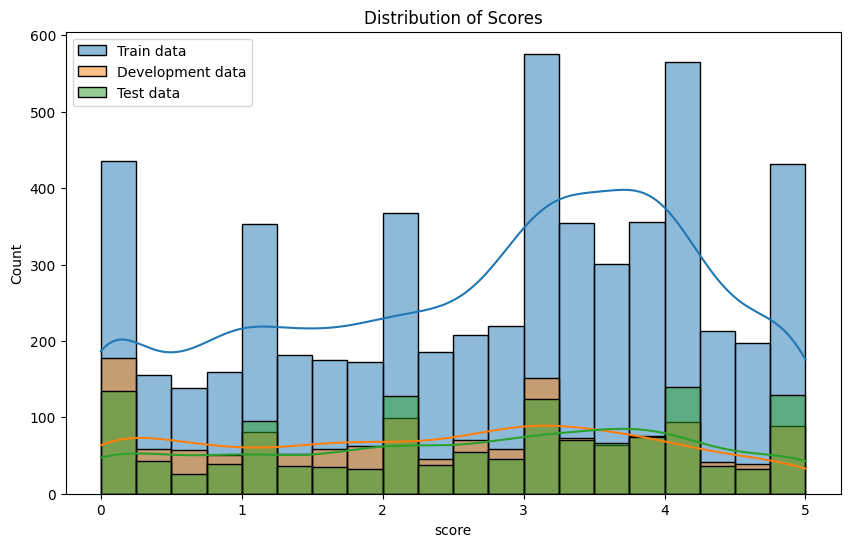

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(df_EDA['score'], label='Train data', kde=True, bins=20)

sns.histplot(df_dev['score'], label='Development data', kde=True, bins=20)
sns.histplot(df_test['score'], label='Test data', kde=True, bins=20)
plt.legend()
plt.title('Distribution of Scores')
plt.show()

Now let's take a look on the years that the data is fetched. From the plot below, we can see that the majority of the data is from 2012 and 2014

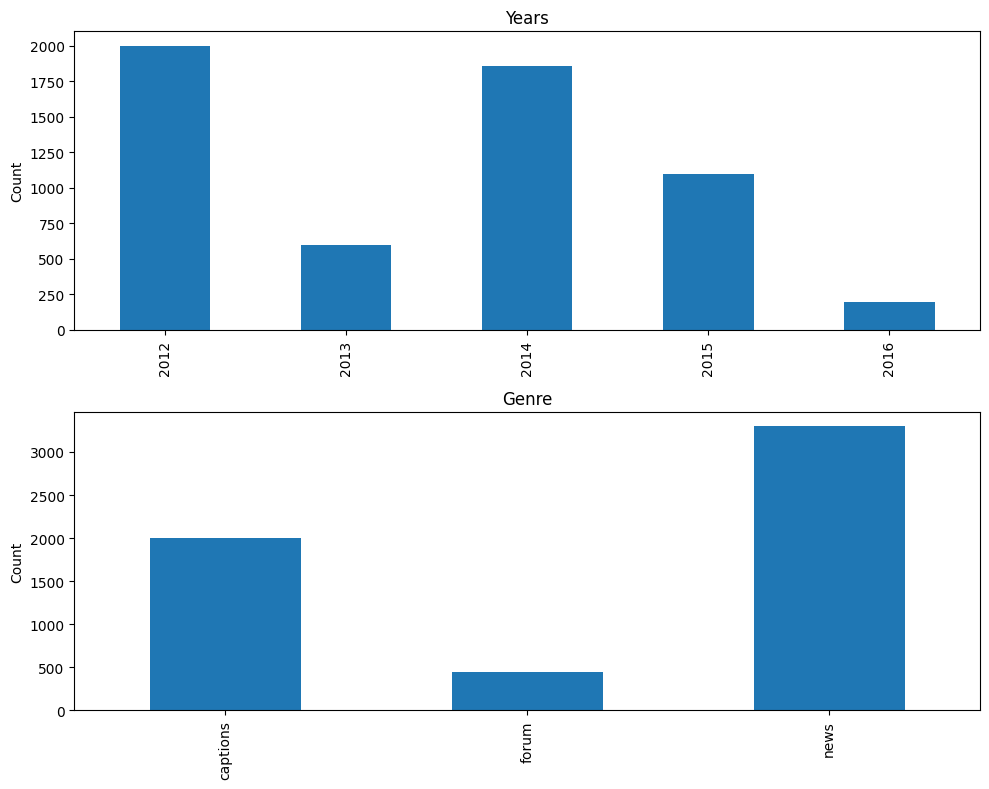

In [ ]:
plt.figure(figsize=(10,8))  # Create a new figure

plt.subplot(211)  # Add a subplot in the first position
df_EDA['years'].value_counts().sort_index().plot(kind='bar')
plt.title('Years')
plt.ylabel('Count')

plt.subplot(212)  # Add a subplot in the second position
df_EDA['genre'].value_counts().sort_index().plot(kind='bar')
plt.title('Genre')
plt.ylabel('Count')

plt.tight_layout()  # This will ensure that the plots do not overlap
plt.show()



Now, let's take a look at how the length of the sentences are distributed. 
From the plot below, we can see that the sentences have a quite similar distribution and are most dense around 5-10 words

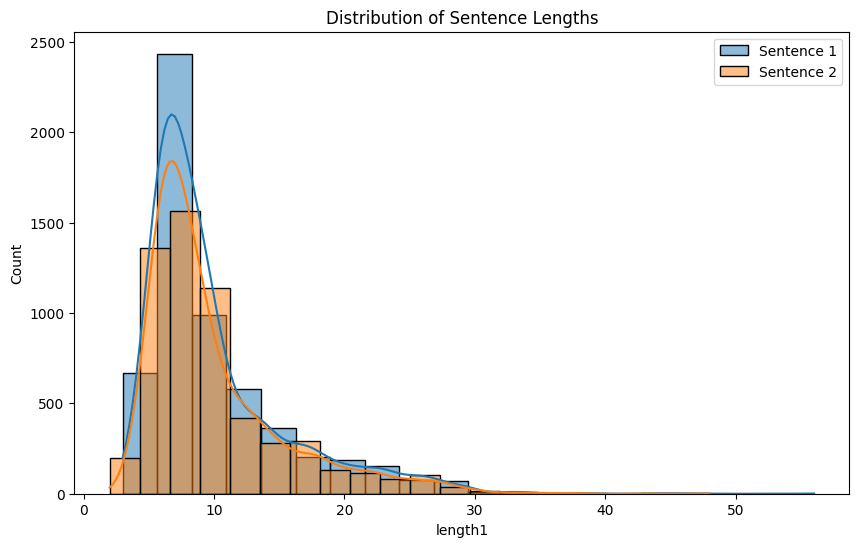

In [ ]:
df_EDA['length1'] = df_EDA['sentence1'].apply(lambda x: len(x.split()))
df_EDA['length2'] = df_EDA['sentence2'].apply(lambda x: len(x.split()))
df_EDA['avg_length'] = (df_EDA['length1'] + df_EDA['length2']) / 2
plt.figure(figsize=(10,6))
sns.histplot(df_EDA['length1'], label='Sentence 1', kde=True, bins=20)
sns.histplot(df_EDA['length2'], label='Sentence 2', kde=True, bins=20)
plt.title('Distribution of Sentence Lengths')
plt.legend()
plt.show()



Below is a plot visualizing how the scores are distributed over different genres. The different distributions are quite similar. The news genre has a slightly higher median than the captions and forum

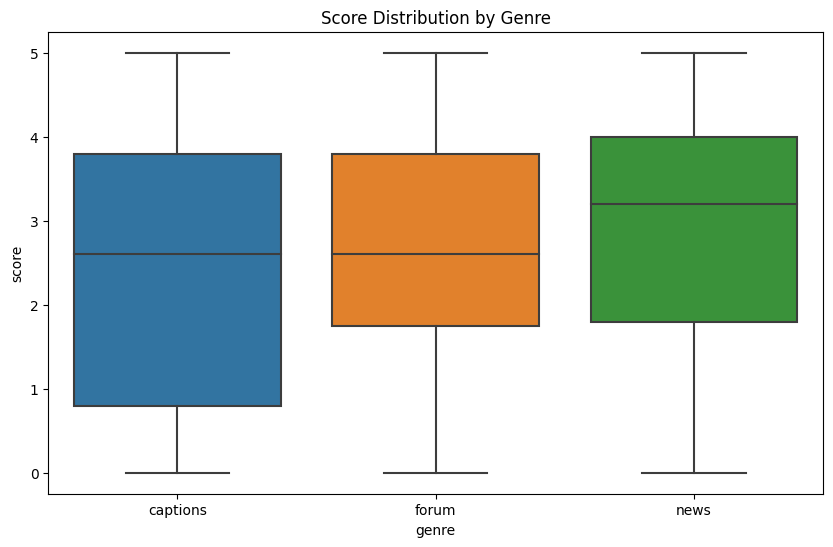

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x='genre', y='score', data=df_EDA)
plt.title('Score Distribution by Genre')
plt.show()



We can do the same with year. 2016 has a lower median than the rest. Keep in mind that 2016 also had the least amount of data.

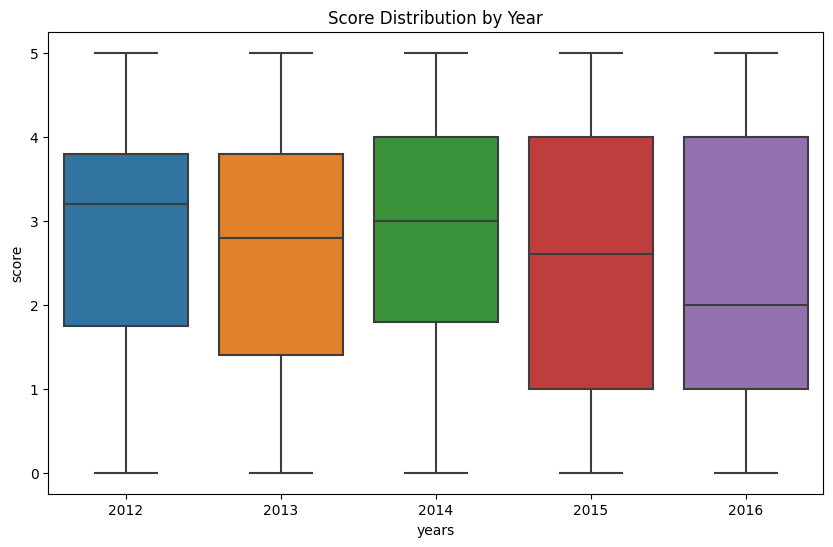

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x='years', y='score', data=df_EDA, order=['2012', '2013', '2014', '2015', '2016'])
plt.title('Score Distribution by Year')
plt.show()


It is of interest to look at how the length of sentences affect the scores. We categorize the average length of a sentence into three categories: Short, medium and long sentences. Then we plot their score distributions

In [ ]:
# Define the boundaries for the categories
bins = [0, 10, 20, np.inf]
names = ['short', 'medium', 'long']

df_EDA['length_cat'] = pd.cut(df_EDA['avg_length'], bins, labels=names)

From the plot below, we can see that the longer sentences tend to have higher scores than the medium and short ones. In fact, no average sentence lengths of higher than 20 have a score of lower than 1

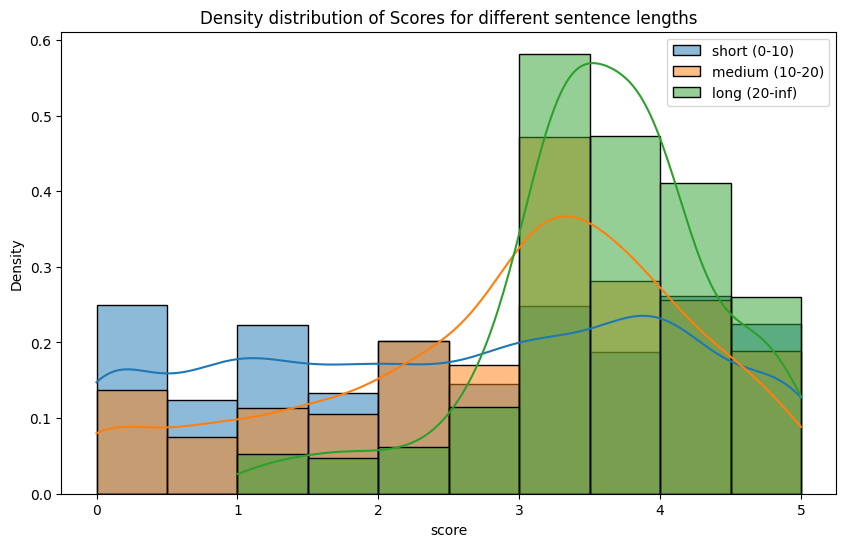

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(df_EDA.loc[df_EDA['length_cat'] == 'short', 'score'], label='short (0-10)', kde=True, bins=score_bins, stat='density')
sns.histplot(df_EDA.loc[df_EDA['length_cat'] == 'medium', 'score'], label='medium (10-20)', kde=True, bins=score_bins, stat='density')
sns.histplot(df_EDA.loc[df_EDA['length_cat'] == 'long', 'score'], label='long (20-inf)', kde=True, bins=score_bins, stat='density')
plt.title('Density distribution of Scores for different sentence lengths')
plt.legend()
plt.show()

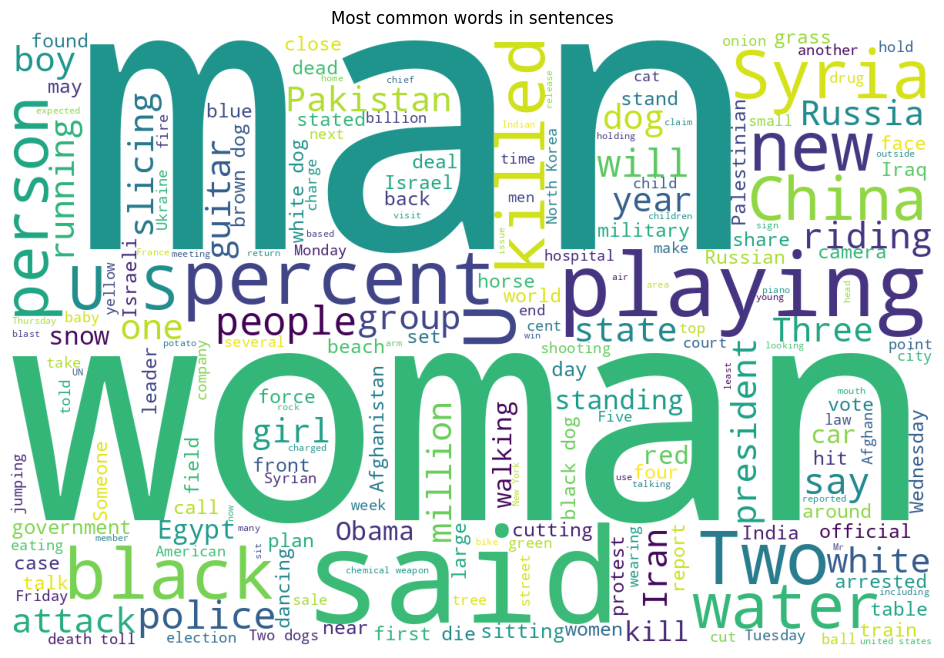

In [ ]:
from wordcloud import WordCloud

all_words = ' '.join(df_EDA['sentence1'].tolist() + df_EDA['sentence2'].tolist())
wordcloud = WordCloud(width = 1200, height = 800, 
                background_color ='white', 
                stopwords = None, 
                min_font_size = 10).generate(all_words)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Most common words in sentences")
plt.show()


In [ ]:
df_EDA['genre'].value_counts()

main-news        3299
main-captions    2000
main-forum        450
Name: genre, dtype: int64

Let's see if the different genres have different score distibutions!
From the below plot, we can see that the captions are more dense in the lowest segment of scores, while the news genre is more dense among the highest

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(df_EDA.loc[df_EDA['genre'] == 'main-news', 'score'], label='news', kde=True, bins=30, stat='density')
sns.histplot(df_EDA.loc[df_EDA['genre'] == 'main-captions', 'score'], label='captions', kde=True, bins=30, stat='density')
sns.histplot(df_EDA.loc[df_EDA['genre'] == 'main-forum', 'score'], label='forum', kde=True, bins=30, stat='density')
plt.title('Distribution of Scores for different genres')
plt.legend()
plt.show()


# TF-IDF similarity

In [ ]:
vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')

In [ ]:
# Extract values of sentence1 and sentence2 into separate 1D lists
train_sentence1 = df_train['sentence1'].tolist()
train_sentence2 = df_train['sentence2'].tolist()
train_sentences = train_sentence1 + train_sentence2

val_sentence1 = df_val['sentence1'].tolist()
val_sentence2 = df_val['sentence2'].tolist()
val_sentences = val_sentence1 + val_sentence2 

test_sentence1 = df_test['sentence1'].tolist()
test_sentence2 = df_test['sentence2'].tolist()
test_sentences = test_sentence1 + test_sentence2


Let's have a quick look at the vocabulary. How big is it?

In [ ]:
# Fit and transform the vectorizer to the sentences
train_vectors = vectorizer.fit_transform(train_sentences)
train_vocab = vectorizer.get_feature_names_out()

test_vectors = vectorizer.fit_transform(test_sentences)
test_vocab = vectorizer.get_feature_names_out()

print(f"Length of vocabulary train: {len(train_vocab)}\n")
print(f"Length of vocabulary test: {len(test_vocab)}\n")
print(test_vocab[0])

Length of vocabulary train: 2910

Length of vocabulary test: 673

000


The decimial values are the TF-IDF scores for the terms. We can sort the terms of the first document by its TF-IDF values, and print them out as follows:

In [ ]:
print(sorted([(test_vocab[j], test_vectors[0, j]) for j in test_vectors[0].nonzero()[1]], key=lambda x: -x[1]))
print(test_sentences[0])

[('hat', 0.5766879000487317), ('hard', 0.5621106714981192), ('dancing', 0.520262868663519), ('man', 0.2842344215877511)]
A man with a hard hat is dancing.


In [ ]:
test_vectors[0].multiply(test_vectors[len(test_sentence1)]).sum() * 5

4.401913919874643

The dot-product between vectors computes the cosine of the angle between them. 
- The cosine of the angle between tf-idf vectors provides a value in the range [0,1], that is often used to measure the similarity between documents.
- Let's compute the similarity between the sentence1 and sentence2 and scale the result by  5 to get the appropriate proportion to the similiarity score.

In [ ]:
train_tf_idf_similarity = []
for i in range(len(train_sentence1)):
    train_tf_idf_similarity.append(train_vectors[i].multiply(train_vectors[i+len(train_sentence1)]).sum()*5)

test_tf_idf_similarity = []
for i in range(len(test_sentence1)):
    test_tf_idf_similarity.append(test_vectors[i].multiply(test_vectors[i+len(test_sentence1)]).sum()*5)

train_results['tf-idf_score'] = train_tf_idf_similarity
test_results['tf-idf_score'] = test_tf_idf_similarity
test_results['diff'] = abs(test_results['score']-test_results['tf-idf_score'])

In [ ]:

test_results.head(5)

,genre,file,years,id,...,sentence1,sentence2,tf-idf_score,diff
0,main-captions,MSRvid,2012test,0,...,A man with a hard hat is dancing.,A man wearing a hard hat is dancing.,4.401914,5.980861e-01
1,main-captions,MSRvid,2012test,2,...,A young child is riding a horse.,A child is riding a horse.,4.377900,3.720999e-01
2,main-captions,MSRvid,2012test,3,...,A man is feeding a mouse to a snake.,The man is feeding a mouse to the snake.,5.000000,8.881784e-16
3,main-captions,MSRvid,2012test,7,...,A woman is playing the guitar.,A man is playing guitar.,3.908029,1.508029e+00
4,main-captions,MSRvid,2012test,8,...,A woman is playing the flute.,A man is playing a flute.,4.130933,1.380933e+00


In [ ]:
test_results_comp = test_results.copy()[['sentence1', 'sentence2', 'score', 'tf-idf_score', 'diff']]

In [ ]:
test_results_comp.loc[test_results_comp['diff'] > 4]

,sentence1,sentence2,score,tf-idf_score,diff
31,A band is performing on a stage.,A band is playing onstage.,5.00,0.000000,5.000000
61,Someone is shredding cabbage leaves with a knife.,Someone is chopping some cabbage leaves.,4.50,0.000000,4.500000
137,A woman is putting on sun glasses.,A woman puts on sunglasses.,5.00,0.791731,4.208269
205,A man is serving cake.,A man seasoning quail.,0.75,5.000000,4.250000
695,"She obviously has a legit excuse, although she...",The first have covers both been more responsib...,0.40,5.000000,4.600000
794,It would be unusual for a snake to attack a st...,"I'm no herpetologist, but in my experience, sn...",4.20,0.000000,4.200000
1282,Jordan Opens First Tent Camp for Syrian Refugees,Jordan Opens First Refugee Camp for Syrians,4.80,0.000000,4.800000
1319,"Clinton: US, Europe must do more against tyrants","Clinton: US, Europe Must Work to Defeat Tyrants",4.40,0.000000,4.400000
1482,Chinese lunar rover lands on moon,China lands robot rover on moon,5.00,0.000000,5.000000


# BM25

In [ ]:
def bm25(df, sentences, vocab, targets, results):
  sentence1 = df['sentence1'].tolist()
  sentence2 = df['sentence2'].tolist()

  preprocessed_docs = [doc.lower().split() for doc in sentences]

  filtered_docs = []
  for doc in preprocessed_docs:
    filtered_docs.append([word for word in doc if word in vocab])
  
  bm25 = BM25Okapi(filtered_docs)

  bm25_similarity = []
  for doc1, doc2 in zip(sentence1, sentence2):
    score1, score2 = bm25.get_scores(doc1.split(" ")), bm25.get_scores(doc2.split(" "))
    bm25_similarity.append(round(cosine_similarity(score1.reshape(1, -1), score2.reshape(1, -1))[0][0]*5, 4))

  mse, rmse, r2 = get_results(targets, bm25_similarity)
  results['bm25_score'] = bm25_similarity


print('Train bm25 score:')
bm25(df_train, train_sentences, train_vocab, train_targets, train_results)
print('Test bm25 score:')
bm25(df_test, test_sentences, test_vocab, test_targets, test_results)

Train bm25 score:
MSE: 3.964
RMSE: 1.991
R2: -0.849

Test bm25 score:
MSE: 3.935
RMSE: 1.984
R2: -0.749



# BOW n-gram similarity

In [ ]:
def get_bow_bi_tri_similarity(sent1, sent2):
  # create count vectorizer
  vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 3))
  vectorizer.fit_transform([sent1, sent2])

  # create bag of words vectors for each sentence
  vec1, vec2 = vectorizer.transform([sent1]), vectorizer.transform([sent2])

  # compute cosine similarity between vectors
  similarity = cosine_similarity(vec1, vec2)
  return (similarity[0][0]*5, vectorizer)

similarity, vectorizer = get_bow_bi_tri_similarity('A plane is taking off.', 'An air plane is taking off.')
vectorizer.get_feature_names_out()

array(['air', 'air plane', 'air plane is', 'an', 'an air', 'an air plane',
       'is', 'is taking', 'is taking off', 'off', 'plane', 'plane is',
       'plane is taking', 'taking', 'taking off'], dtype=object)

In [ ]:
train_bow_bi_tri_similarity = []
for _, (sentence1, sentence2, _) in df_train.iterrows():
    train_bow_bi_tri_similarity.append(get_bow_bi_tri_similarity(sentence1, sentence2)[0])

test_bow_bi_tri_similarity = []
for _, (sentence1, sentence2, _) in df_test.iterrows():
    test_bow_bi_tri_similarity.append(get_bow_bi_tri_similarity(sentence1, sentence2)[0])

In [ ]:
train_results['bow_score'] = train_bow_bi_tri_similarity
test_results['bow_score'] = test_bow_bi_tri_similarity
test_results.head(5)

,genre,file,years,id,...,tf-idf_score,diff,bm25_score,bow_score
0,main-captions,MSRvid,2012test,0,...,4.401914,5.980861e-01,4.7638,3.333333
1,main-captions,MSRvid,2012test,2,...,4.377900,3.720999e-01,4.2875,4.330127
2,main-captions,MSRvid,2012test,3,...,5.000000,8.881784e-16,5.0000,3.499482
3,main-captions,MSRvid,2012test,7,...,3.908029,1.508029e+00,2.8089,1.924501
4,main-captions,MSRvid,2012test,8,...,4.130933,1.380933e+00,2.8089,1.924501


# Average word embeddings

In [ ]:
# Load pre-trained Word2Vec model
fasttext_wiki = api.load("fasttext-wiki-news-subwords-300")
embeddings = [(fasttext_wiki, 'fasttext-wiki-news-subwords-300')]

[==================================================] 100.0% 958.5/958.4MB downloaded


In [ ]:
def avg_embedding_sentence_similarity(sentences1, sentences2, model):
    similarities = []
    for sent1, sent2 in zip(sentences1, sentences2):
        # Tokenize the sentences
        sent1_tokens = nltk.word_tokenize(sent1.lower())
        sent2_tokens = nltk.word_tokenize(sent2.lower())
        
        # Compute the average embedding for each sentence
        sent1_embedding = np.mean([model.get_vector(word) for word in sent1_tokens if word in model.key_to_index], axis=0)
        sent2_embedding = np.mean([model.get_vector(word) for word in sent2_tokens if word in model.key_to_index], axis=0)
        
        # Compute the cosine similarity between the two embeddings
        similarity = cosine_similarity([sent1_embedding], [sent2_embedding])[0][0]*5
        similarities.append(similarity)
    return similarities
similarity_train = avg_embedding_sentence_similarity(train_sentence1, train_sentence2, fasttext_wiki)
similarity_test = avg_embedding_sentence_similarity(test_sentence1, test_sentence2, fasttext_wiki)
similarity_valid = avg_embedding_sentence_similarity(val_sentence1, val_sentence2, fasttext_wiki)
# Reshape your data since sklearn requires input to be 2D array
similarity_train = np.array(similarity_train).reshape(-1, 1)
similarity_test = np.array(similarity_test).reshape(-1, 1)
similarity_valid = np.array(similarity_valid).reshape(-1, 1)



In [ ]:
avg_embedding_reg = find_polynomial_and_write_results(5, similarity_train, similarity_valid, similarity_test, 'avg_embedding_score', train_targets, val_targets, test_targets)

Degree: 1, Validation MSE: 1.8913401037822888
Degree: 2, Validation MSE: 1.8471299159566386
Degree: 3, Validation MSE: 1.8304092035362707
Degree: 4, Validation MSE: 1.8264787876161548
Best degree: 4, Validation MSE: 1.8264787876161548
Best mse:  1.8970174814619174


# Doc2Vec

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
# Tokenize all sentences and create a TaggedDocument for each sentence
all_sentences = train_sentences + val_sentences + test_sentences
tokenized_sentences = [nltk.word_tokenize(sentence.lower()) for sentence in all_sentences]
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_sentences)]

# Train a Doc2Vec model on all sentences
model = Doc2Vec(tagged_data)


In [ ]:

def doc2vec(sentences1, sentences2, model):
    doc2vec_similarity = []
    for sentence1, sentence2 in zip(sentences1, sentences2):
        vector_1 = model.infer_vector(nltk.word_tokenize(sentence1.lower()))
        vector_2 = model.infer_vector(nltk.word_tokenize(sentence2.lower()))
        doc2vec_similarity.append(np.diagonal(cosine_similarity(vector_1.reshape(1, -1), vector_2.reshape(1, -1))))
    return doc2vec_similarity


similarity_train = doc2vec(train_sentence1, train_sentence2, model)
similarity_test = doc2vec(test_sentence1, test_sentence2, model)
similarity_valid = doc2vec(val_sentence1, val_sentence2, model)
# Reshape your data since sklearn requires input to be 2D array
similarity_train = np.array(similarity_train).reshape(-1, 1)
similarity_test = np.array(similarity_test).reshape(-1, 1)
similarity_valid = np.array(similarity_valid).reshape(-1, 1)



In [ ]:
doc2vec_reg = find_polynomial_and_write_results(5, similarity_train, similarity_valid, similarity_test, 'doc2vec_score', train_targets, val_targets, test_targets)

Degree: 1, Validation MSE: 1.808153717410048
Degree: 2, Validation MSE: 1.8074229967039048
Degree: 3, Validation MSE: 1.8074181937179905
Degree: 4, Validation MSE: 1.808803807188638
Best degree: 3, Validation MSE: 1.8074181937179905
Best mse:  1.6925325711599362


#Word Mover's Distance (WMD) 

is a method used to measure the semantic similarity between two sentences. It takes into account the distance between word embeddings in a vector space.

In [ ]:
word_vectors = fasttext_wiki

def wmd(sentences1, sentences2):
  wmd_similarity = []
  for sentence1, sentence2 in zip(sentences1, sentences2):
    sent1_tokens = nltk.word_tokenize(sentence1.lower())
    sent2_tokens = nltk.word_tokenize(sentence2.lower())
    instance = WmdSimilarity([sent1_tokens], word_vectors)
    similarity = instance.get_similarities([sent2_tokens])[0]
    wmd_similarity.append(similarity)
  return wmd_similarity

similarity_train = wmd(train_sentence1, train_sentence2)
similarity_test = wmd(test_sentence1, test_sentence2)
similarity_valid = wmd(val_sentence1, val_sentence2)
# Reshape your data since sklearn requires input to be 2D array
similarity_train = np.array(similarity_train).reshape(-1, 1)
similarity_test = np.array(similarity_test).reshape(-1, 1)
similarity_valid = np.array(similarity_valid).reshape(-1, 1)



In [ ]:
wmd_reg = find_polynomial_and_write_results(20, similarity_train, similarity_valid, similarity_test, 'wmd_score', train_targets, val_targets, test_targets)

Degree: 1, Validation MSE: 1.6127695309015813
Degree: 2, Validation MSE: 1.5677195479390484
Degree: 3, Validation MSE: 1.5674148261398115
Degree: 4, Validation MSE: 1.5627821624318043
Degree: 5, Validation MSE: 1.5546728125457805
Degree: 6, Validation MSE: 1.5543950125671724
Degree: 7, Validation MSE: 1.554674937069531
Degree: 8, Validation MSE: 1.5520057099096267
Degree: 9, Validation MSE: 1.552300518624007
Degree: 10, Validation MSE: 1.5523822672258232
Degree: 11, Validation MSE: 1.5521992039765304
Degree: 12, Validation MSE: 1.5520332257954634
Degree: 13, Validation MSE: 1.553443431792741
Degree: 14, Validation MSE: 1.5541939835928207
Degree: 15, Validation MSE: 1.5540774613781825
Degree: 16, Validation MSE: 1.5538563588835987
Degree: 17, Validation MSE: 1.5532579658080785
Degree: 18, Validation MSE: 1.5531344252475394
Degree: 19, Validation MSE: 1.5534047488795606
Best degree: 8, Validation MSE: 1.5520057099096267
Best mse:  1.4528787844675686


# Universal Sentence Encoder


The Universal Sentence Encoder (USE) is a natural language processing (NLP) model developed by Google that converts sentences or short texts into fixed-length vector representations, also known as embeddings. These embeddings capture the semantic meaning of the sentences and enable various downstream tasks, such as text classification, clustering, semantic similarity calculation, and more. The USE model is based on deep learning techniques, specifically using a variation of the Transformer architecture. 

In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)
print ("module %s loaded" % module_url)

logging.set_verbosity(logging.ERROR)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [ ]:
def use(sentence1, sentence2):
  similarity = []
  embeddings1 = model(sentence1)
  embeddings2 = model(sentence2)
  similarity = np.diagonal(cosine_similarity(embeddings1, embeddings2)).reshape(-1,1)
  return similarity

similarity_train = use(train_sentence1, train_sentence2)
similarity_valid = use(val_sentence1, val_sentence2)
similarity_test = use(test_sentence1, test_sentence2)

In [ ]:
use_reg = find_polynomial_and_write_results(20, similarity_train, similarity_valid, similarity_test, 'use_score', train_targets, val_targets, test_targets)

Degree: 1, Validation MSE: 0.8521547371490016
Degree: 2, Validation MSE: 0.824094421736926
Degree: 3, Validation MSE: 0.8089749759671413
Degree: 4, Validation MSE: 0.8183867277296574
Degree: 5, Validation MSE: 0.8101683893292277
Degree: 6, Validation MSE: 0.8110170305264955
Degree: 7, Validation MSE: 0.8088983539574571
Degree: 8, Validation MSE: 0.8089095871819914
Degree: 9, Validation MSE: 0.8087173723332519
Degree: 10, Validation MSE: 0.8078601346471234
Degree: 11, Validation MSE: 0.823638256093447
Degree: 12, Validation MSE: 0.8106858055993736
Degree: 13, Validation MSE: 0.8082064245607007
Degree: 14, Validation MSE: 0.9433617383598369
Degree: 15, Validation MSE: 0.8984807459347418
Degree: 16, Validation MSE: 0.9007234217460024
Degree: 17, Validation MSE: 0.8644036474062141
Degree: 18, Validation MSE: 0.837803968506954
Degree: 19, Validation MSE: 0.8254993862597356
Best degree: 10, Validation MSE: 0.8078601346471234
Best mse:  0.8078601346471234


# InferSent

InferSent is a sentence embeddings method that utilizes a bi-directional LSTM (Long Short-Term Memory) network to encode sentences into fixed-length vectors. It is trained on various natural language understanding tasks, enabling it to capture sentence semantics and infer similarity.

https://github.com/facebookresearch/InferSent?fbclid=IwAR0j7JJDc4HiTtg1fKMVjDMYDFw7EqALWWygDsAGiRVeSGQ6oednJfUozHc

In [ ]:
# !git clone https://github.com/facebookresearch/InferSent.git
# !wget http://nlp.stanford.edu/data/glove.840B.300d.zip
# !unzip glove.840B.300d.zip
%cd InferSent
from models import InferSent
%cd ..

/content/drive/.shortcut-targets-by-id/1xZJmJJual5U8lzIwXIr0F2zYXS374a47/NLP Project/InferSent
/content/drive/.shortcut-targets-by-id/1xZJmJJual5U8lzIwXIr0F2zYXS374a47/NLP Project


In [ ]:
model_version = 1
MODEL_PATH = 'encoder/infersent%s.pkl' % model_version
W2V_PATH = 'glove.840B.300d.txt'
VOCAB_SIZE = 1e4  # Load embeddings of VOCAB_SIZE most frequent words
USE_CUDA = False  # Keep it on CPU if False, otherwise will put it on GPU

In [ ]:
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
model = InferSent(params_model)
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type != 'cuda':
    raise SystemError('GPU device not found')

In [ ]:
model = model.to(device)
model.set_w2v_path(W2V_PATH)
# model.build_vocab_k_words(K=VOCAB_SIZE)
model.build_vocab(train_sentences + val_sentences + test_sentences, tokenize=True)

Found 17559(/18457) words with w2v vectors
Vocab size : 17559


In [ ]:
def infersent(sentences1, sentences2):
  embeddings1 = model.encode(sentences1, tokenize=True, verbose=False) # bsize=128
  embeddings2 = model.encode(sentences2, tokenize=True, verbose=False) # bsize=128

  infersent_sim = np.diagonal(cosine_similarity(embeddings1, embeddings2)).reshape()
  return infersent_sim
similarity_train = infersent(train_sentence1, train_sentence2)
similarity_valid = infersent(val_sentence1, val_sentence2)
similarity_test = infersent(test_sentence1, test_sentence2)

/content/drive/.shortcut-targets-by-id/1xZJmJJual5U8lzIwXIr0F2zYXS374a47/NLP Project/InferSent/models.py:207: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sentences = np.array(sentences)[idx_sort]
/content/drive/.shortcut-targets-by-id/1xZJmJJual5U8lzIwXIr0F2zYXS374a47/NLP Project/InferSent/models.py:207: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sentences = np.array(sentences)[idx_sort]
/content/drive/.shortcut-targets-by-id/1xZJmJJual5U8lzIwXIr0F2zYXS374a47/NLP Project/InferSent/models.py:207: VisibleDeprecationWarning: Creating an ndarray fro

In [ ]:
similarity_train = similarity_train.reshape(-1,1)
similarity_valid = similarity_valid.reshape(-1,1)
similarity_test = similarity_test.reshape(-1,1)

In [ ]:
use_reg = find_polynomial_and_write_results(20, similarity_train, similarity_valid, similarity_test, 'infersent_score', train_targets, val_targets, test_targets)

Degree: 1, Validation MSE: 1.024905302419149
Degree: 2, Validation MSE: 1.0023382510699446
Degree: 3, Validation MSE: 0.9857872404845666
Degree: 4, Validation MSE: 0.9888753523062266
Degree: 5, Validation MSE: 0.9880631820872415
Degree: 6, Validation MSE: 0.9880945332233677
Degree: 7, Validation MSE: 0.9956078390465855
Degree: 8, Validation MSE: 0.9930782339790873
Degree: 9, Validation MSE: 0.990413137700537
Degree: 10, Validation MSE: 0.9906282869411172
Degree: 11, Validation MSE: 0.9908896945551448
Degree: 12, Validation MSE: 0.9909988579017217
Degree: 13, Validation MSE: 0.9905868588749802
Degree: 14, Validation MSE: 0.9926051239606783
Degree: 15, Validation MSE: 0.9920922905386236
Degree: 16, Validation MSE: 0.9913755434175162
Degree: 17, Validation MSE: 0.9912749089837963
Degree: 18, Validation MSE: 0.9912067003474836
Degree: 19, Validation MSE: 0.9919904122162538
Best degree: 3, Validation MSE: 0.9857872404845666
Best mse:  0.9857872404845666


# BERT

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type != 'cuda':
    raise SystemError('GPU device not found')

In [ ]:
# For sentence pair classification, ktrain expects a list of tuples of form (str, str)
x_train = df_train[['sentence1', 'sentence2']].values
x_train = list(map(tuple, x_train))

x_test = df_test[['sentence1', 'sentence2']].values
x_test = list(map(tuple, x_test))

y_train = df_train['score'].values
y_test = df_test['score'].values
print(x_test)

[('A man with a hard hat is dancing.', 'A man wearing a hard hat is dancing.'), ('A young child is riding a horse.', 'A child is riding a horse.'), ('A man is feeding a mouse to a snake.', 'The man is feeding a mouse to the snake.'), ('A woman is playing the guitar.', 'A man is playing guitar.'), ('A woman is playing the flute.', 'A man is playing a flute.'), ('A woman is cutting an onion.', 'A man is cutting onions.'), ('A man is erasing a chalk board.', 'The man is erasing the chalk board.'), ('A woman is carrying a boy.', 'A woman is carrying her baby.'), ('Three men are playing guitars.', 'Three men are on stage playing guitars.'), ('A woman peels a potato.', 'A woman is peeling a potato.'), ('People are playing cricket.', 'Men are playing cricket.'), ('A man is playing a guitar.', 'A man is playing a flute.'), ('The cougar is chasing the bear.', 'A cougar is chasing a bear.'), ('The man cut down a tree with an axe.', 'A man chops down a tree with an axe.'), ('The man is playing th

In [ ]:
# Load a pre-trained transformer model
model_name = 'bert-base-cased'
transformer = text.Transformer(model_name, maxlen=512)

Run the learner to do some simulated runs and try to determine the best setting of the learning rate.

In [ ]:
processed_train = transformer.preprocess_train(x_train, y_train)
processed_test = transformer.preprocess_test(x_test, y_test)
model = transformer.get_classifier()
learner = ktrain.get_learner(model, train_data=processed_train, val_data=processed_test, batch_size=6)
# learner.lr_find(show_plot=True, max_epochs=1)

preprocessing train...
language: en
sentence pairs detected


/usr/local/lib/python3.10/dist-packages/ktrain/utils.py:727: UserWarning: Task is being treated as REGRESSION because either class_names argument was not supplied or is_regression=True. If this is incorrect, change accordingly.
  warnings.warn(


preprocessing test...
language: en
sentence pairs detected


/usr/local/lib/python3.10/dist-packages/ktrain/text/preprocessor.py:1126: UserWarning: no class labels were provided - treating as regression
  warnings.warn("no class labels were provided - treating as regression")


Based on the plot above, we'll select a learning rate of 5*10^-5. The recommendation from ktrain is to choose as big a value as possible where the loss is still decreasing 

lr 5*10^-3 Test MSE: 2.328

lr 5*10^-4 Test MSE: 2.379

lr 3*10^-4 Test MSE: 0.583

lr 5*10^-5 Test MSE: 0.575

lr 7*10^-5 Test MSE: 0.577

lr 1*10^-5 Test MSE: 0.689




lr 5*10^-5:

1 epoch, 6 batch: Train MSE: 0.595, Test MSE: 0.779

2 epoch, 6 batch: Train MSE: 0.223, Test MSE: 0.578

3 epoch, 6 batch: Train MSE: 0.154, Test MSE: 0.575

10 epoch using autofit, Train MSE: 0.081, Test MSE: 0.59



In [ ]:
learner.fit_onecycle(5e-5, 1)
# learner.autofit(5e-5)

predictor = ktrain.get_predictor(learner.model, transformer)
train_bert_similarity = predictor.predict(x_train)

print("Train:")
train_results['bert_score'] = train_bert_similarity
get_results(train_targets, train_bert_similarity)


learner.fit_onecycle(5e-5, 1)
predictor = ktrain.get_predictor(learner.model, transformer)
test_bert_similarity = predictor.predict(x_test)

print("Test:")
test_results['bert_score'] = test_bert_similarity
get_results(test_targets, test_bert_similarity)

del model
torch.cuda.empty_cache()

test_results.head(5)



begin training using onecycle policy with max lr of 5e-05...
952/952 [==============================] - 705s 716ms/step - loss: 1.4838 - mae: 0.9197 - val_loss: 0.6253 - val_mae: 0.6049
Train:
MSE: 0.428
RMSE: 0.654
R2: 0.801



begin training using onecycle policy with max lr of 5e-05...
952/952 [==============================] - 680s 713ms/step - loss: 0.5951 - mae: 0.5921 - val_loss: 0.6183 - val_mae: 0.5977
Test:
MSE: 0.618
RMSE: 0.786
R2: 0.726



,genre,file,years,id,...,use_score,inferSent_score,siamese_score,bert_score
0,main-captions,MSRvid,2012test,0.0,...,4.880369,0.939172,2.295531,4.459205
1,main-captions,MSRvid,2012test,2.0,...,4.822934,0.909844,2.295792,4.513896
2,main-captions,MSRvid,2012test,3.0,...,4.681888,0.976473,2.369368,4.506437
3,main-captions,MSRvid,2012test,7.0,...,4.187535,0.858675,2.295883,2.300284
4,main-captions,MSRvid,2012test,8.0,...,4.263165,0.895003,2.294697,2.387350


# RoBERTa

In [ ]:
model_name = 'roberta-base'
transformer = text.Transformer(model_name, maxlen=512)
processed_train = transformer.preprocess_train(x_train, y_train)
processed_test = transformer.preprocess_test(x_test, y_test)
model = transformer.get_classifier()
learner = ktrain.get_learner(model, train_data=processed_train, val_data=processed_test, batch_size=6)

preprocessing train...
language: en
sentence pairs detected


/usr/local/lib/python3.10/dist-packages/ktrain/utils.py:727: UserWarning: Task is being treated as REGRESSION because either class_names argument was not supplied or is_regression=True. If this is incorrect, change accordingly.
  warnings.warn(


preprocessing test...
language: en
sentence pairs detected


/usr/local/lib/python3.10/dist-packages/ktrain/text/preprocessor.py:1126: UserWarning: no class labels were provided - treating as regression
  warnings.warn("no class labels were provided - treating as regression")


roberta-base:


1 epoch Train MSE: 0.383 Test MSE: 0.548

2 epochs: Train MSE: 0.25 Test MSE: 0.485

3 epochs: Train MSE: 0.229 Test MSE: 0.495




In [ ]:
learner.fit_onecycle(5e-5, 1)

predictor = ktrain.get_predictor(learner.model, transformer)
train_roberta_similarity = predictor.predict(x_train)

print("Train:")
train_results['roberta_score'] = train_roberta_similarity
get_results(train_targets, train_roberta_similarity)

learner.fit_onecycle(5e-5, 1)
predictor = ktrain.get_predictor(learner.model, transformer)
test_roberta_similarity = predictor.predict(x_test)

print("Test:")
test_results['roberta_score'] = test_roberta_similarity
get_results(test_targets, test_roberta_similarity)

del model
torch.cuda.empty_cache()

test_results.head(5)



begin training using onecycle policy with max lr of 5e-05...
952/952 [==============================] - 734s 749ms/step - loss: 1.2449 - mae: 0.8614 - val_loss: 0.5824 - val_mae: 0.5990
Train:
MSE: 0.434
RMSE: 0.659
R2: 0.798



begin training using onecycle policy with max lr of 5e-05...
952/952 [==============================] - 709s 744ms/step - loss: 0.5591 - mae: 0.5869 - val_loss: 0.5303 - val_mae: 0.5529
Test:
MSE: 0.53
RMSE: 0.728
R2: 0.765



,genre,file,years,id,...,inferSent_score,siamese_score,bert_score,roberta_score
0,main-captions,MSRvid,2012test,0.0,...,0.939172,2.295531,4.459205,4.624313
1,main-captions,MSRvid,2012test,2.0,...,0.909844,2.295792,4.513896,4.608617
2,main-captions,MSRvid,2012test,3.0,...,0.976473,2.369368,4.506437,4.620626
3,main-captions,MSRvid,2012test,7.0,...,0.858675,2.295883,2.300284,2.147142
4,main-captions,MSRvid,2012test,8.0,...,0.895003,2.294697,2.387350,2.205875


# GPT2

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, AdamW
from tqdm.notebook import tqdm

In [ ]:
model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=1)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

class SentenceSimilarityDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attention_mask[idx], self.labels[idx]


def preprocess_data(sentence_pairs, similarity_scores):
    tokenizer.pad_token = tokenizer.eos_token
    tokenized_pairs = tokenizer.batch_encode_plus(
        sentence_pairs,
        padding=True,
        truncation=True,
        return_tensors="pt"
    )
    input_ids = tokenized_pairs["input_ids"]
    attention_mask = tokenized_pairs["attention_mask"]
    labels = torch.tensor(similarity_scores)
    return input_ids, attention_mask, labels


In [ ]:
def fine_tune_model(trian_input_ids, train_attention_mask, train_labels, test_input_ids, test_attention_mask, test_labels):
    model.resize_token_embeddings(len(tokenizer))
    model.config.pad_token_id = model.config.eos_token_id
    optimizer = AdamW(model.parameters(), lr=1e-5)

    train_dataset = SentenceSimilarityDataset(trian_input_ids, train_attention_mask, train_labels)
    train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
    test_dataset = SentenceSimilarityDataset(test_input_ids, test_attention_mask, test_labels)
    test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True)

    model.train()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    num_epochs = 3
    for epoch in range(num_epochs):
        tqdm_train = tqdm(train_dataloader, total=len(train_dataloader))
        tqdm_test = tqdm(test_dataloader, total=len(test_dataloader))

        total_loss = 0
        train_similarities = []
        model.train()
        for batch in tqdm_train:
            batch = [item.to(device) for item in batch]
            input_ids, attention_mask, labels = batch
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            train_similarities += torch.flatten(outputs.logits).tolist()
            loss = outputs.loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        average_loss = total_loss / len(train_dataloader)
        print(f"Epoch: {epoch + 1}, Average Loss: {average_loss}")
        get_results(train_labels, train_similarities)

        valid_similarities = []
        model.eval()
        with torch.no_grad():
          for batch in tqdm_test:
            batch = [item.to(device) for item in batch]
            input_ids, attention_mask, labels = batch
            similarity = torch.flatten(model(input_ids=input_ids, attention_mask=attention_mask).logits)
            valid_similarities += similarity.tolist()
        get_results(test_labels, valid_similarities)

    train_results['gpt2_score'] = train_similarities
    test_results['gpt2_score'] = valid_similarities

    return model

In [ ]:
# For sentence pair classification, ktrain expects a list of tuples of form (str, str)
x_train = df_train[['sentence1', 'sentence2']].values
x_train = list(map(list, x_train))

x_test = df_test[['sentence1', 'sentence2']].values
x_test = list(map(list, x_test))

y_train = torch.tensor(df_train['score'].values, dtype=torch.float32)
y_test = torch.tensor(df_test['score'].values, dtype=torch.float32)

train_input_ids, trian_attention_mask, trian_labels = preprocess_data(x_train, y_train)
test_input_ids, test_attention_mask, test_labels = preprocess_data(x_test, y_test)

model = fine_tune_model(train_input_ids, trian_attention_mask, trian_labels, test_input_ids, test_attention_mask, test_labels )

<ipython-input-42-836abe0a6a1d>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(similarity_scores)


  0%|          | 0/1903 [00:00<?, ?it/s]

  0%|          | 0/488 [00:00<?, ?it/s]

OutOfMemoryError: ignored

# Sentence-BERT

Sentence Embeddings using Siamese BERT-Networks

## all-MiniLM-L6-v2 

The all-* models where trained on all available training data (more than 1 billion training pairs) and are designed as general purpose models. The all-mpnet-base-v2 model provides the best quality, while all-MiniLM-L6-v2 is 5 times faster and still offers good quality. 
(https://huggingface.co/tasks/sentence-similarity)

In [ ]:
device = torch.device('cuda')

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2').to(device)

def miniLM(df, results, targets):
  train_sentences1 = df['sentence1'].values
  train_sentences2 = df['sentence2'].values

  #Compute embedding for both lists
  embedding_1 = model.encode(train_sentences1, convert_to_tensor=True) 
  embedding_2 = model.encode(train_sentences2, convert_to_tensor=True)

  MiniLM_similarity = torch.diagonal(util.pytorch_cos_sim((embedding_1), (embedding_2))).cpu()
  MiniLM_similarity[MiniLM_similarity < 0] = 0 # Sentences that are opposing should just be zero
  MiniLM_similarity = MiniLM_similarity * 5
  results['miniLM_score'] = MiniLM_similarity
  get_results(targets, MiniLM_similarity)

miniLM(df_train, train_results, train_targets)
miniLM(df_test, test_results, test_targets)

## all-mpnet-base-v2

In [ ]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

def mpnet(df, results, targets):
  train_sentences1 = df['sentence1'].values
  train_sentences2 = df['sentence2'].values

  # Compute embedding for both lists
  embedding_1 = model.encode(train_sentences1, convert_to_tensor=True) 
  embedding_2 = model.encode(train_sentences2, convert_to_tensor=True)

  mpnet_similarity = torch.diagonal(util.pytorch_cos_sim(embedding_1, embedding_2)).cpu()
  mpnet_similarity[mpnet_similarity < 0] = 0 # Sentences that are opposing should just be zero
  mpnet_similarity = mpnet_similarity * 5
  results['mpnet_score'] = mpnet_similarity
  get_results(targets, mpnet_similarity)

mpnet(df_train, train_results, train_targets)
mpnet(df_test, test_results, test_targets)

# Stacking with LightGBM

A problem with using this ensemble method is that the feature importance might be biased on BERT because the score from the training is overfitted. We tested this issue and noticed that romving the BERT score improved the final score significantly.

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

features = ['tf-idf_score', 'bm25_score', 'bow_score' , 'avg_embeddings_score', 'doc2vec_score', 'wmd_score',
            'use_score', 'inferSent_score', 'siamese_score', 'bert_score', 'roberta_score', 'gpt2_score',
            'miniLM_score', 'mpnet_score']

x_train = train_results[features].values
x_test  =  test_results[features].values
y_train = df_train['score'].values
y_test = df_test['score'].values

# Convert your data to LightGBM dataset format
train_data = lgb.Dataset(x_train, label=y_train)

# Set up the parameters for LightGBM training
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 14,
    'learning_rate': 0.07,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 4,
    'verbose': 0
}

# Train the LightGBM model
model = lgb.train(params, train_data, num_boost_round=250)

# Make predictions on the test set
y_pred = model.predict(x_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

In [ ]:
model.feature_importances_

# K-fold cross validation

For the cross validation, we only train three models in order to save some computation time.

In [ ]:
from sklearn.model_selection import KFold
# Define number of splits
n_splits = 3
kf = KFold(n_splits=n_splits)


### Fetching the data

In [ ]:
bad_lines_left = []
def bad_lines(row):
  print(len(row), row)
  bad_lines_left.append(row)

original_bad_lines = []
def all_bad_lines(row):
  original_bad_lines.append(row)

columns = ['genre', 'file', 'years', 'id', 'score', 'sentence1', 'sentence2']

train = pd.read_csv('data/sts-train-clean.csv', engine='python', encoding='utf-8',index_col=False, sep='~', quotechar='\x07', header=None, on_bad_lines=bad_lines, names=columns)
dirty_train = pd.read_csv('data/original/sts-train.csv', engine='python', encoding='utf-8', sep=',', header=None, on_bad_lines=all_bad_lines)
print(f'train rows: {len(train)}')
print(f'difference in number of lines: {len(train)-len(dirty_train)}')
print(f'bad lines left: {len(bad_lines_left)}')
print(f'lines with nan:', len(train[train.isnull().any(axis=1)]), '\n')

bad_lines_left, original_bad_lines = [], []

dev = pd.read_csv('data/sts-dev-clean.csv', engine='python', sep='~',  quotechar='\x07',index_col=False, header=None, on_bad_lines=bad_lines, names=columns)
dirty_dev = pd.read_csv('data/original/sts-dev.csv', engine='python', sep=',', header=None, on_bad_lines=all_bad_lines)
print(f'dev rows: {len(dev)}')
print(f'difference in number of lines: {len(dev)-len(dirty_dev)}')
print(f'bad lines left: {len(bad_lines_left)}')
print(f'lines with nan:', len(dev[dev.isnull().any(axis=1)]), '\n')
dev = dev.dropna()
bad_lines_left, original_bad_lines = [], []

test = pd.read_csv('data/sts-test-clean.csv', engine='python', sep='~',  quotechar='\x07',index_col=False, header=None, on_bad_lines=bad_lines, names=columns)
dirty_test = pd.read_csv('data/original/sts-test.csv', engine='python', sep=',', header=None, on_bad_lines=all_bad_lines)
print(f'test rows: {len(test)}')
print(f'difference in number of lines: {len(test)-len(dirty_test)}')
print(f'bad lines left: {len(bad_lines_left)}')
print(f'test with nan:', len(test[test.isnull().any(axis=1)]), '\n')
test = test.dropna()
bad_lines_left, original_bad_lines = [], []


train rows: 5749
difference in number of lines: 1571
bad lines left: 0
lines with nan: 0 

dev rows: 1500
difference in number of lines: 537
bad lines left: 0
lines with nan: 0 

test rows: 1379
difference in number of lines: 347
bad lines left: 0
test with nan: 0 



In [ ]:
df_train = pd.concat([train[['sentence1', 'sentence2', 'score']].copy(), dev[['sentence1', 'sentence2', 'score']].copy()], ignore_index=True)
df_test = test[['sentence1', 'sentence2', 'score']].copy()


df_train['score'] = df_train['score'].astype(float)
df_test['score'] = df_test['score'].astype(float)

test_results = test.copy()
train_results = train.copy()

test_targets = df_test['score'].values
train_targets = df_train['score'].values

In [ ]:
# Extract values of sentence1 and sentence2 into separate 1D lists
train_sentence1 = df_train['sentence1'].tolist()
train_sentence2 = df_train['sentence2'].tolist()
train_sentences = train_sentence1 + train_sentence2



test_sentence1 = df_test['sentence1'].tolist()
test_sentence2 = df_test['sentence2'].tolist()
test_sentences = test_sentence1 + test_sentence2

In [ ]:
# For sentence pair classification, ktrain expects a list of tuples of form (str, str)
x_train = df_train[['sentence1', 'sentence2']].values
x_train = list(map(tuple, x_train))

x_test = df_test[['sentence1', 'sentence2']].values
x_test = list(map(tuple, x_test))

y_train = df_train['score'].values
y_test = df_test['score'].values
print(x_test)

[('A girl is styling her hair.', 'A girl is brushing her hair.'), ('A group of men play soccer on the beach.', 'A group of boys are playing soccer on the beach.'), ("One woman is measuring another woman's ankle.", "A woman measures another woman's ankle."), ('A man is cutting up a cucumber.', 'A man is slicing a cucumber.'), ('A man is playing a harp.', 'A man is playing a keyboard.'), ('A woman is cutting onions.', 'A woman is cutting tofu.'), ('A man is riding an electric bicycle.', 'A man is riding a bicycle.'), ('A man is playing the drums.', 'A man is playing the guitar.'), ('A man is playing guitar.', 'A lady is playing the guitar.'), ('A man is playing a guitar.', 'A man is playing a trumpet.'), ('A man is playing a guitar.', 'A man is playing a trumpet.'), ('A man is cutting an onion.', 'A man cuts an onion.'), ('A man is cycling.', 'A man is talking.'), ('A man is slicing open a fish.', 'A man is cutting up a fish.'), ('A man is slicing a tomato.', 'A man is slicing a bun.'), 

In [ ]:
# Store validation predictions for each fold
oof_predictions = np.zeros((len(df_train),4))

# Convert sentences and scores into arrays
sentences = df_train[['sentence1', 'sentence2']].values
scores = df_train['score'].values

### Training the models

#### InferSent

In [ ]:
%cd InferSent
from models import InferSent
%cd ..

/content/drive/.shortcut-targets-by-id/1xZJmJJual5U8lzIwXIr0F2zYXS374a47/NLP Project/InferSent
/content/drive/.shortcut-targets-by-id/1xZJmJJual5U8lzIwXIr0F2zYXS374a47/NLP Project


In [ ]:
model_version = 1
MODEL_PATH = 'encoder/infersent%s.pkl' % model_version
W2V_PATH = 'glove.840B.300d.txt'
VOCAB_SIZE = 1e4  # Load embeddings of VOCAB_SIZE most frequent words
USE_CUDA = False  # Keep it on CPU if False, otherwise will put it on GPU

In [ ]:
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': model_version}
model = InferSent(params_model)
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [ ]:
model = model.cuda() if USE_CUDA else model
model.set_w2v_path(W2V_PATH)
# model.build_vocab_k_words(K=VOCAB_SIZE)

NameError: ignored

In [ ]:
def infersent_cv(sentences1, sentences2, targets):
  model.build_vocab(sentences1 + sentences2, tokenize=True)

  embeddings1 = model.encode(sentences1, tokenize=True, verbose=False) # bsize=128
  embeddings2 = model.encode(sentences2, tokenize=True, verbose=False) # bsize=128

  infersent_sim = np.diagonal(cosine_similarity(embeddings1, embeddings2))
  get_results(targets, infersent_sim)
  return infersent_sim

#infersent(train_sentence1, train_sentence2, train_targets, train_results)
#infersent(test_sentence1, test_sentence2, test_targets, test_results)

In [ ]:
#infersent
oof_predictions[:, 0] = infersent_cv(sentences[:,0], sentences[:,1], scores)

Found 16178(/21221) words with w2v vectors
Vocab size : 16178


/content/drive/.shortcut-targets-by-id/1xZJmJJual5U8lzIwXIr0F2zYXS374a47/NLP Project/InferSent/models.py:207: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sentences = np.array(sentences)[idx_sort]


In [ ]:
print(oof_predictions[:5, 0])

#### WMD

In [ ]:
word_vectors = fasttext_wiki

def wmd_cv(sentences1, sentences2, targets):
  wmd_similarity = []
  for sentence1, sentence2 in zip(sentences1, sentences2):
    sent1_tokens = nltk.word_tokenize(sentence1.lower())
    sent2_tokens = nltk.word_tokenize(sentence2.lower())
    instance = WmdSimilarity([sent1_tokens], word_vectors)
    similarity = instance.get_similarities([sent2_tokens])[0]
    wmd_similarity.append(similarity)

  get_results(targets, wmd_similarity)
  return wmd_similarity

In [ ]:
oof_predictions[:,1] = wmd_cv(sentences[:,0], sentences[:,0], scores)

#### Siamese

In [ ]:
import keras
import keras.backend as K
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.layers import ZeroPadding2D, Activation, Input, concatenate, Embedding, LSTM, GRU
from keras.models import Model
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.layers import Input, Dense, Flatten, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract, Add, Conv2D

In [ ]:
vocab_size = 400
max_length = 15    # Max length of input sentences
tf.keras.utils.set_random_seed(42)

tok = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tok.fit_on_texts(train_sentences + test_sentences)

# Padding sequences to a max embedding length of 100 dim and max len of the sequence to 300
train_q1_seq = tok.texts_to_sequences(train_sentence1)
train_q2_seq = tok.texts_to_sequences(train_sentence2)

val_q1_seq = tok.texts_to_sequences(test_sentence1)
val_q2_seq = tok.texts_to_sequences(test_sentence2)


train_q1_seq = tf.keras.utils.pad_sequences(train_q1_seq, maxlen=max_length, padding='post')
train_q2_seq = tf.keras.utils.pad_sequences(train_q2_seq, maxlen=max_length, padding='post')

val_q1_seq = tf.keras.utils.pad_sequences(val_q1_seq, maxlen=max_length, padding='post')
val_q2_seq = tf.keras.utils.pad_sequences(val_q2_seq, maxlen=max_length, padding='post')

print(train_q1_seq[0], train_q2_seq[0], train_targets[0])

In [ ]:
# parameters
embed_size = 400    # Size of word embeddings
units = 3

# define base network for siamese model
def create_base_network():
    input = Input(shape=(max_length,), dtype='int32')
    x = Embedding(vocab_size, embed_size, input_length=max_length)(input)
    x = keras.layers.LSTM(units, kernel_regularizer=l2(0.01))(x)  # add L2 regularization
    # x = keras.layers.Dropout(0.5)(x) 
    return Model(inputs=input, outputs=x)

# siamese model
base_network = create_base_network()

input_a = Input(shape=(max_length,))
input_b = Input(shape=(max_length,))

processed_a = base_network(input_a)
processed_b = base_network(input_b)

# calculate euclidean distance
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([processed_a, processed_b])
similarity_score = Dense(1, activation='sigmoid')(L1_distance)
scaled_similarity_score = Lambda(lambda x: x * 5)(similarity_score)  # scale the output to the range 0-5

# Model Training with K-Fold CV
for train_index, val_index in kf.split(sentences):

    model = Model(inputs=[input_a, input_b], outputs=scaled_similarity_score)

    # compile model
    optimizer = Adam(lr=0.001)  # gradient clipping to avoid exploding gradients
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error'])

    # print model summary
    # model.summary()
    model.fit([train_q1_seq[train_index],train_q2_seq[train_index]], train_targets[train_index], epochs=20,
              batch_size=4, validation_data=([train_q1_seq[val_index], train_q2_seq[val_index]], train_targets[train_index]))
    score = model.evaluate([train_q1_seq[val_index], train_q2_seq[val_index]], train_targets[train_index], verbose=0)
    oof_predictions[val_index, 3] = score.reshape(-1,1)
    

#### Bert

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type != 'cuda':
    #raise SystemError('GPU device not found')

SystemError: ignored

In [ ]:
# Load a pre-trained transformer model
model_name = 'bert-base-cased'
transformer = text.Transformer(model_name, maxlen=512)

In [ ]:
model = transformer.get_classifier()


/usr/local/lib/python3.10/dist-packages/ktrain/text/preprocessor.py:392: UserWarning: The method preprocess_train was never called. You can disable this warning by setting preprocess_train_called=True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/ktrain/text/preprocessor.py:1126: UserWarning: no class labels were provided - treating as regression
  warnings.warn("no class labels were provided - treating as regression")


In [ ]:
from sklearn.model_selection import KFold


# Model Training with K-Fold CV
for train_index, val_index in kf.split(sentences):

    train_sentences, val_sentences = sentences[train_index], sentences[val_index]
    train_scores, val_scores = scores[train_index], scores[val_index]
    
    # Combine sentence pairs into tuples
    train_sentence_pairs = list(map(tuple, train_sentences))
    val_sentence_pairs = list(map(tuple, val_sentences))

    # Preprocess the sentences
    train_data = transformer.preprocess_train(train_sentence_pairs, train_scores)
    val_data = transformer.preprocess_test(val_sentence_pairs, val_scores)
    


    # Create a new learner for each fold
    learner = ktrain.get_learner(model, train_data=train_data, val_data=val_data, batch_size=8)

    # Train the model with early stopping 
    learner.fit_onecycle(5e-5, 1)
    learner.fit_onecycle(4e-5, 1)
    # Generate predictions
    predictor = ktrain.get_predictor(learner.model, transformer)
    val_pred = predictor.predict(val_sentence_pairs)
    oof_predictions[val_index, 4] = val_pred.reshape(-1,1)




# Evaluate model performance using oof predictions
print("OOF Score: ", mean_squared_error(scores, oof_predictions, squared=False))


preprocessing train...
language: en
sentence pairs detected


/usr/local/lib/python3.10/dist-packages/ktrain/utils.py:727: UserWarning: Task is being treated as REGRESSION because either class_names argument was not supplied or is_regression=True. If this is incorrect, change accordingly.
  warnings.warn(


preprocessing test...
language: en
sentence pairs detected


ValueError: ignored